In [1]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid


from py_wake.turbulence_models import GCLTurbulence
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite
from py_wake.superposition_models import LinearSum

from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020

from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

from py_wake.wind_turbines import WindTurbine, WindTurbines

In [2]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9 #wind speed
YD=0   #yaw direction
TI=0 #turbulence intensity

p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205]  # sector frequencies
#p_wd = np.ones(12) / 12
a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803]         # Weibull scale parameter
k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172]          # Weibull shape parameter

#site
from py_wake.site.xrsite import XRSite
import xarray as xr
site=XRSite(ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', p_wd), 'Weibull_A': ('wd', a), 'Weibull_k': ('wd', k), 'TI': TI},
                  coords={'wd': np.linspace(0, 360, len(p_wd), endpoint=False)}))

from wind_turbine_object import create_wind_turbine 


REAL WIND FARM OPTIMIZATION

In [ ]:
# Lillgrund farm west side configuration

import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

SIZEPOP=100 #change for accuracy
MAXITER=20 #change for accuracy
coefficients_bs=np.loadtxt('coefficients_bs.txt')
coefficients_cs=np.loadtxt('coefficients_cs.txt')
coefficients_bf=np.loadtxt('coefficients_bf.txt')
coefficients_cf=np.loadtxt('coefficients_cf.txt')

wd=260 #change here the wind direction studied

alpha_degrees=wd-WD #deg
alpha_radians = np.radians(alpha_degrees)
# Define the polynomial function
def polynomial_function(coefficients, x):
    degree = len(coefficients) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients))
    return f

# Define the evaluation function
def evaluate(x):
    x1, x2, x3, x4 , x5 = x

    params1 = [
        polynomial_function(coefficients_bs, x1),
        polynomial_function(coefficients_cs, x1),
        polynomial_function(coefficients_bf, x1),
        polynomial_function(coefficients_cf, x1)
    ]

    params2 = [
        polynomial_function(coefficients_bs, x2),
        polynomial_function(coefficients_cs, x2),
        polynomial_function(coefficients_bf, x2),
        polynomial_function(coefficients_cf, x2)
    ]

    params3 = [
        polynomial_function(coefficients_bs, x3),
        polynomial_function(coefficients_cs, x3),
        polynomial_function(coefficients_bf, x3),
        polynomial_function(coefficients_cf, x3)
    ]

    params4 = [
        polynomial_function(coefficients_bs, x4),
        polynomial_function(coefficients_cs, x4),
        polynomial_function(coefficients_bf, x4),
        polynomial_function(coefficients_cf, x4)
    ]
    params5 = [
    polynomial_function(coefficients_bs, x5),
    polynomial_function(coefficients_cs, x5),
    polynomial_function(coefficients_bf, x5),
    polynomial_function(coefficients_cf, x5)
]

    # First turbine
    x_array = np.array([0])
    y_array = np.array([0])
    d_array = np.sqrt(x_array**2 + y_array**2)
    theta_array = np.arctan2(y_array, x_array) 
    new_x = d_array * np.cos(theta_array - alpha_radians)
    new_y = d_array * np.sin(theta_array - alpha_radians)
    wind_turbine1=create_wind_turbine(x1, D, H)
    wind_farm_model = All2AllIterative(site, wind_turbine1, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params1[0], c_s=params1[1],
                        b_f=params1[2], c_f=params1[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    sim_res = wind_farm_model(new_x, new_y, wd=WD, ws=WS, yaw=YD)
    power1 = sim_res.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6

    # Flow box for first turbine
    flow_box = wind_farm_model(new_x,new_y, wd=np.arange(WD-1,WD+1)).flow_box(
        x=np.linspace(-D, 26*D, 101),
        y=np.linspace( - 6*D,  6*D, 101),
        h=H)
    wake_site = XRSite.from_flow_box(flow_box)

    # Second turbine
    x_array_2 = np.array([2.85 * D])
    y_array_2 = np.array([1.65*D])
    d_array_2 = np.sqrt(x_array_2**2 + y_array_2**2)
    theta_array_2 = np.arctan2(y_array_2, x_array_2) 
    new_x_2 = d_array_2 * np.cos(theta_array_2 - alpha_radians)
    new_y_2 = d_array_2 * np.sin(theta_array_2 - alpha_radians)
    wind_turbine2=create_wind_turbine(x2, D, H)
    wind_farm_model_2 = All2AllIterative(wake_site, wind_turbine2, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params2[0], c_s=params2[1],
                        b_f=params2[2], c_f=params2[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    sim_res_2 = wind_farm_model_2(new_x_2, new_y_2, wd=WD, ws=WS, yaw=YD)
    power2 = sim_res_2.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6

    # Flow box for second turbine
    flow_box_2 = wind_farm_model_2(new_x_2,new_y_2, wd=np.arange(WD-1,WD+1)).flow_box(
        x=np.linspace(-D, 26*D , 101),
        y=np.linspace(0 - 6*D,  6*D , 101),
        h=H)
    wake_site_2 = XRSite.from_flow_box(flow_box_2)

    # Third turbine
    x_array_3 = np.array([5.7*D])
    y_array_3 = np.array([3.3*D])
    d_array_3 = np.sqrt(x_array_3**2 + y_array_3**2)
    theta_array_3 = np.arctan2(y_array_3, x_array_3) 
    new_x_3 = d_array_3 * np.cos(theta_array_3 - alpha_radians)
    new_y_3 = d_array_3 * np.sin(theta_array_3 - alpha_radians)
    wind_turbine3=create_wind_turbine(x3, D, H)
    wind_farm_model_3 = All2AllIterative(wake_site_2, wind_turbine3, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params3[0], c_s=params3[1],
                        b_f=params3[2], c_f=params3[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    sim_res_3 = wind_farm_model_3(new_x_3, new_y_3, wd=WD, ws=WS, yaw=YD)
    power3 = sim_res_3.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6

    # Flow box for third turbine
    flow_box_3 = wind_farm_model_3(new_x_3, new_y_3, wd=np.arange(WD-1,WD+1)).flow_box(
        x=np.linspace(-D, 26*D - 1, 101),
        y=np.linspace(0 - 6*D,  6*D , 101),
        h=H)
    wake_site_3 = XRSite.from_flow_box(flow_box_3)

    # Fourth turbine
    x_array_4 = np.array([8.58*D])
    y_array_4 = np.array([-0.05*D])
    d_array_4 = np.sqrt(x_array_4**2 + y_array_4**2)
    theta_array_4 = np.arctan2(y_array_4, x_array_4) 
    new_x_4 = d_array_4 * np.cos(theta_array_4 - alpha_radians)
    new_y_4 = d_array_4 * np.sin(theta_array_4 - alpha_radians)
    wind_turbine4=create_wind_turbine(x4, D, H)
    wind_farm_model_4 = All2AllIterative(wake_site_3, wind_turbine4, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params4[0], c_s=params4[1],
                        b_f=params4[2], c_f=params4[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    sim_res_4 = wind_farm_model_4(new_x_4, new_y_4, wd=WD, ws=WS, yaw=YD)
    power4 = sim_res_4.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
    

    # Flow box for forth turbine
    flow_box_4 = wind_farm_model_4(new_x_4,new_y_4, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D -1, 101),
    y=np.linspace(0 - 6*D, 0 + 6*D, 101),
    h=H)
    wake_site_4 = XRSite.from_flow_box(flow_box_4)
    

    # Fifth turbine
    x_array_5 = np.array([ 4*2.85 * D])
    y_array_5 = np.array([ 1.6*D])
    d_array_5 = np.sqrt(x_array_5**2 + y_array_5**2)
    theta_array_5 = np.arctan2(y_array_5, x_array_5) 
    new_x_5 = d_array_5 * np.cos(theta_array_5 - alpha_radians)
    new_y_5 = d_array_5 * np.sin(theta_array_5 - alpha_radians)
    wind_turbine5=create_wind_turbine(x5, D, H)
    wind_farm_model_5 = All2AllIterative(wake_site_4, wind_turbine5, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params5[0], c_s=params5[1],
                    b_f=params5[2], c_f=params5[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    sim_res_5 = wind_farm_model_5(new_x_5, new_y_5, wd=WD, ws=WS, yaw=YD)
    power5=sim_res_5.Power.sel(ws=WS,wt=0, wd=WD).sum().values/1e6
    wind5 = sim_res_5.flow_map(grid=XYGrid(x=np.linspace(-D, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(2*6*D/10)),h=H)).WS_eff.values.squeeze()

    total_power = power1 + power2 + power3 + power4+ power5

    if np.any(np.isnan(wind5)):
        total_power=-10**36


    # Return negative total power because GA in sko minimizes the function
    return -total_power

# Set the range for the helix angles
lb = [0] * 5  # lower bounds
ub = [5] * 5  # upper bounds

# Genetic Algorithm setup
ga = GA(func=evaluate, n_dim=5, size_pop=SIZEPOP, max_iter=MAXITER, lb=lb, ub=ub, prob_mut=0.001, precision=1e-7)

best_x, best_y = ga.run()

print('Best Helix Angles:', best_x)
print('Best Total Power (MW):', -best_y)

# Plot the results
plt.plot(ga.all_history_Y)
plt.xlabel('Generation')
plt.ylabel('Total Power (negative)')
plt.title('Genetic Algorithm Optimization')
plt.show()




#plot
x1, x2, x3, x4 , x5 = best_x
params1 = [
    polynomial_function(coefficients_bs, x1),
    polynomial_function(coefficients_cs, x1),
    polynomial_function(coefficients_bf, x1),
    polynomial_function(coefficients_cf, x1)
]
params2 = [
    polynomial_function(coefficients_bs, x2),
    polynomial_function(coefficients_cs, x2),
    polynomial_function(coefficients_bf, x2),
    polynomial_function(coefficients_cf, x2)
]
params3 = [
    polynomial_function(coefficients_bs, x3),
    polynomial_function(coefficients_cs, x3),
    polynomial_function(coefficients_bf, x3),
    polynomial_function(coefficients_cf, x3)
]
params4 = [
    polynomial_function(coefficients_bs, x4),
    polynomial_function(coefficients_cs, x4),
    polynomial_function(coefficients_bf, x4),
    polynomial_function(coefficients_cf, x4)
]
params5 = [
    polynomial_function(coefficients_bs, x5),
    polynomial_function(coefficients_cs, x5),
    polynomial_function(coefficients_bf, x5),
    polynomial_function(coefficients_cf, x5)
]

# First turbine
x_array = np.array([0])
y_array = np.array([0])
d_array = np.sqrt(x_array**2 + y_array**2)
theta_array = np.arctan2(y_array, x_array) 
new_x = d_array * np.cos(theta_array - alpha_radians)
new_y = d_array * np.sin(theta_array - alpha_radians)
wind_turbine1=create_wind_turbine(best_x[0], D, H)
wind_farm_model = All2AllIterative(site, wind_turbine1, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params1[0], c_s=params1[1],
                    b_f=params1[2], c_f=params1[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res = wind_farm_model(new_x, new_y, wd=WD, ws=WS, yaw=YD)
power1 = sim_res.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind1_opt = sim_res.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for first turbine
flow_box = wind_farm_model(new_x,new_y, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D, 101),
    y=np.linspace( - 6*D,  6*D, 101),
    h=H)
wake_site = XRSite.from_flow_box(flow_box)

# Second turbine
x_array_2 = np.array([2.85 * D])
y_array_2 = np.array([1.65*D])
d_array_2 = np.sqrt(x_array_2**2 + y_array_2**2)
theta_array_2 = np.arctan2(y_array_2, x_array_2) 
new_x_2 = d_array_2 * np.cos(theta_array_2 - alpha_radians)
new_y_2 = d_array_2 * np.sin(theta_array_2 - alpha_radians)
wind_turbine2=create_wind_turbine(best_x[1], D, H)
wind_farm_model_2 = All2AllIterative(wake_site, wind_turbine2, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params2[0], c_s=params2[1],
                    b_f=params2[2], c_f=params2[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_2 = wind_farm_model_2(new_x_2, new_y_2, wd=WD, ws=WS, yaw=YD)
power2 = sim_res_2.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind2_opt = sim_res_2.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for second turbine
flow_box_2 = wind_farm_model_2(new_x_2,new_y_2, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D , 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_2 = XRSite.from_flow_box(flow_box_2)

# Third turbine
x_array_3 = np.array([5.7*D])
y_array_3 = np.array([3.3*D])
d_array_3 = np.sqrt(x_array_3**2 + y_array_3**2)
theta_array_3 = np.arctan2(y_array_3, x_array_3) 
new_x_3 = d_array_3 * np.cos(theta_array_3 - alpha_radians)
new_y_3 = d_array_3 * np.sin(theta_array_3 - alpha_radians)
wind_turbine3=create_wind_turbine(best_x[2], D, H)
wind_farm_model_3 = All2AllIterative(wake_site_2, wind_turbine3, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params3[0], c_s=params3[1],
                    b_f=params3[2], c_f=params3[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_3 = wind_farm_model_3(new_x_3, new_y_3, wd=WD, ws=WS, yaw=YD)
power3 = sim_res_3.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind3_opt = sim_res_3.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for third turbine
flow_box_3 = wind_farm_model_3(new_x_3, new_y_3, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D - 1, 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_3 = XRSite.from_flow_box(flow_box_3)

# Fourth turbine
x_array_4 = np.array([8.58*D])
y_array_4 = np.array([-0.05*D])
d_array_4 = np.sqrt(x_array_4**2 + y_array_4**2)
theta_array_4 = np.arctan2(y_array_4, x_array_4) 
new_x_4 = d_array_4 * np.cos(theta_array_4 - alpha_radians)
new_y_4 = d_array_4 * np.sin(theta_array_4 - alpha_radians)
wind_turbine4=create_wind_turbine(best_x[3], D, H)
wind_farm_model_4 = All2AllIterative(wake_site_3, wind_turbine4, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params4[0], c_s=params4[1],
                    b_f=params4[2], c_f=params4[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_4 = wind_farm_model_4(new_x_4, new_y_4, wd=WD, ws=WS, yaw=YD)
power4 = sim_res_4.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind4_opt = sim_res_4.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for third turbine
flow_box_4 = wind_farm_model_4(new_x_4,new_y_4, wd=np.arange(WD-1,WD+1)).flow_box(
x=np.linspace(-D, 26*D -1, 101),
y=np.linspace(0 - 6*D, 0 + 6*D, 101),
h=H)
wake_site_4 = XRSite.from_flow_box(flow_box_4)


# Fifth turbine
x_array_5 = np.array([ 4*2.85 * D])
y_array_5 = np.array([ 1.6*D])
d_array_5 = np.sqrt(x_array_5**2 + y_array_5**2)
theta_array_5 = np.arctan2(y_array_5, x_array_5) 
new_x_5 = d_array_5 * np.cos(theta_array_5 - alpha_radians)
new_y_5 = d_array_5 * np.sin(theta_array_5 - alpha_radians)
wind_turbine5=create_wind_turbine(best_x[4], D, H)
wind_farm_model_5 = All2AllIterative(wake_site_4, wind_turbine5, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params5[0], c_s=params5[1],
                b_f=params5[2], c_f=params5[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_5 = wind_farm_model_5(new_x_5, new_y_5, wd=WD, ws=WS, yaw=YD)
power5=sim_res_5.Power.sel(ws=WS,wt=0, wd=WD).sum().values/1e6

wind5_opt = sim_res_5.flow_map(grid=XYGrid(x=np.linspace(-D, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Define the positions and values to be plotted
x_positions = [new_x[0]+20, new_x_2[0]/10+20, new_x_3[0]/10+20, new_x_4[0]/10+20, new_x_5[0]/10+20]  # Replace with actual positions
y_positions = [new_y[0]+130, new_y_2[0]/10+130, new_y_3[0]/10+130, new_y_4[0]/10+130, new_y_5[0]/10+130]  # Replace with actual positions
values = [round(power1, 2), round(power2, 2), round(power3, 2), round(power4, 2), round(power5, 2)]  # Replace with actual values
names = ["D08", "C08", "B08", "B07", "A07"]  # List of turbine names in order
pitch_amplitudes = best_x  # Assuming best_x contains the pitch amplitudes in the right order

fig = plt.figure(figsize=(16, 6))
im = plt.imshow(wind5_opt, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')  # Add colorbar with label
plt.title(f'Lillgrund wind farm - Wind direction = \n{wd}°', fontsize=12, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)

for x, y, value, name, pitch in zip(x_positions, y_positions, values, names, pitch_amplitudes):
    rounded_pitch = round(pitch, 1)  # Round the pitch amplitude to the first decimal place
    plt.text(x, y, f'{name}\nPower: {value} MW\nPitch Angle: {rounded_pitch} °', color='black', fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5))



output_path = rf'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\8_Lillgrund_WEST_5configuration_{wd}_new.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

# Create the filename with the angle included
filename = f'power_{wd}.txt'
np.savetxt(filename, values)









# Define the positions and values to be plotted
x_positions = [new_x[0]+50, new_x_2[0]/10+50, new_x_3[0]/10+50, new_x_4[0]/10+50, new_x_5[0]/10+50]  # Replace with actual positions
y_positions = [new_y[0]+130, new_y_2[0]/10+130, new_y_3[0]/10+130, new_y_4[0]/10+130, new_y_5[0]/10+130]  # Replace with actual positions
values = [round(power1, 2), round(power2, 2), round(power3, 2), round(power4, 2), round(power5, 2)]  # Replace with actual values
names = ["D08", "C08", "B08", "B07", "A07"]  # List of turbine names in order
pitch_amplitudes = best_x  # Assuming best_x contains the pitch amplitudes in the right order

fig = plt.figure(figsize=(16, 6))
im = plt.imshow(wind5_opt, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')  # Add colorbar with label
plt.title(f'Lillgrund wind farm - Wind direction = \n{wd}°', fontsize=12, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)

for x, y, value, name, pitch in zip(x_positions, y_positions, values, names, pitch_amplitudes):
    rounded_pitch = round(pitch, 1)  # Round the pitch amplitude to the first decimal place
    plt.text(x, y, f'{name}\nPower: {value} MW\nPitch Angle: {rounded_pitch} °', color='black', fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5))



output_path = rf'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\8_Lillgrund_WEST_5configuration_{wd}_newreal.png'
#plt.savefig(output_path, bbox_inches='tight')
plt.show()

# Create the filename with the angle included
filename = f'power_{wd}.txt'
#np.savetxt(filename, values)



In [ ]:
#plot
coefficients_bs=np.loadtxt('coefficients_bs.txt')
coefficients_cs=np.loadtxt('coefficients_cs.txt')
coefficients_bf=np.loadtxt('coefficients_bf.txt')
coefficients_cf=np.loadtxt('coefficients_cf.txt')
wd=300
WD=270
alpha_degrees=wd-WD #deg
alpha_radians = np.radians(alpha_degrees)
# Define the polynomial function
def polynomial_function(coefficients, x):
    degree = len(coefficients) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients))
    return f

best_x=np.array([5,5,0.2,5,0.1])
x1, x2, x3, x4 , x5 = best_x
params1 = [
    polynomial_function(coefficients_bs, x1),
    polynomial_function(coefficients_cs, x1),
    polynomial_function(coefficients_bf, x1),
    polynomial_function(coefficients_cf, x1)
]
params2 = [
    polynomial_function(coefficients_bs, x2),
    polynomial_function(coefficients_cs, x2),
    polynomial_function(coefficients_bf, x2),
    polynomial_function(coefficients_cf, x2)
]
params3 = [
    polynomial_function(coefficients_bs, x3),
    polynomial_function(coefficients_cs, x3),
    polynomial_function(coefficients_bf, x3),
    polynomial_function(coefficients_cf, x3)
]
params4 = [
    polynomial_function(coefficients_bs, x4),
    polynomial_function(coefficients_cs, x4),
    polynomial_function(coefficients_bf, x4),
    polynomial_function(coefficients_cf, x4)
]
params5 = [
    polynomial_function(coefficients_bs, x5),
    polynomial_function(coefficients_cs, x5),
    polynomial_function(coefficients_bf, x5),
    polynomial_function(coefficients_cf, x5)
]

# First turbine
x_array = np.array([0])
y_array = np.array([0])
d_array = np.sqrt(x_array**2 + y_array**2)
theta_array = np.arctan2(y_array, x_array) 
new_x = d_array * np.cos(theta_array - alpha_radians)
new_y = d_array * np.sin(theta_array - alpha_radians)
wind_turbine1=create_wind_turbine(best_x[0], D, H)
wind_farm_model = All2AllIterative(site, wind_turbine1, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params1[0], c_s=params1[1],
                    b_f=params1[2], c_f=params1[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res = wind_farm_model(new_x, new_y, wd=WD, ws=WS, yaw=YD)
power1 = sim_res.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind1_opt = sim_res.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for first turbine
flow_box = wind_farm_model(new_x,new_y, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D, 101),
    y=np.linspace( - 6*D,  6*D, 101),
    h=H)
wake_site = XRSite.from_flow_box(flow_box)

# Second turbine
x_array_2 = np.array([2.85 * D])
y_array_2 = np.array([1.65*D])
d_array_2 = np.sqrt(x_array_2**2 + y_array_2**2)
theta_array_2 = np.arctan2(y_array_2, x_array_2) 
new_x_2 = d_array_2 * np.cos(theta_array_2 - alpha_radians)
new_y_2 = d_array_2 * np.sin(theta_array_2 - alpha_radians)
wind_turbine2=create_wind_turbine(best_x[1], D, H)
wind_farm_model_2 = All2AllIterative(wake_site, wind_turbine2, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params2[0], c_s=params2[1],
                    b_f=params2[2], c_f=params2[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_2 = wind_farm_model_2(new_x_2, new_y_2, wd=WD, ws=WS, yaw=YD)
power2 = sim_res_2.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind2_opt = sim_res_2.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for second turbine
flow_box_2 = wind_farm_model_2(new_x_2,new_y_2, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D , 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_2 = XRSite.from_flow_box(flow_box_2)

# Third turbine
x_array_3 = np.array([5.7*D])
y_array_3 = np.array([3.3*D])
d_array_3 = np.sqrt(x_array_3**2 + y_array_3**2)
theta_array_3 = np.arctan2(y_array_3, x_array_3) 
new_x_3 = d_array_3 * np.cos(theta_array_3 - alpha_radians)
new_y_3 = d_array_3 * np.sin(theta_array_3 - alpha_radians)
wind_turbine3=create_wind_turbine(best_x[2], D, H)
wind_farm_model_3 = All2AllIterative(wake_site_2, wind_turbine3, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params3[0], c_s=params3[1],
                    b_f=params3[2], c_f=params3[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_3 = wind_farm_model_3(new_x_3, new_y_3, wd=WD, ws=WS, yaw=YD)
power3 = sim_res_3.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind3_opt = sim_res_3.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for third turbine
flow_box_3 = wind_farm_model_3(new_x_3, new_y_3, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D - 1, 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_3 = XRSite.from_flow_box(flow_box_3)

# Fourth turbine
x_array_4 = np.array([8.58*D])
y_array_4 = np.array([-0.05*D])
d_array_4 = np.sqrt(x_array_4**2 + y_array_4**2)
theta_array_4 = np.arctan2(y_array_4, x_array_4) 
new_x_4 = d_array_4 * np.cos(theta_array_4 - alpha_radians)
new_y_4 = d_array_4 * np.sin(theta_array_4 - alpha_radians)
wind_turbine4=create_wind_turbine(best_x[3], D, H)
wind_farm_model_4 = All2AllIterative(wake_site_3, wind_turbine4, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params4[0], c_s=params4[1],
                    b_f=params4[2], c_f=params4[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_4 = wind_farm_model_4(new_x_4, new_y_4, wd=WD, ws=WS, yaw=YD)
power4 = sim_res_4.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind4_opt = sim_res_4.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for third turbine
flow_box_4 = wind_farm_model_4(new_x_4,new_y_4, wd=np.arange(WD-1,WD+1)).flow_box(
x=np.linspace(-D, 26*D -1, 101),
y=np.linspace(0 - 6*D, 0 + 6*D, 101),
h=H)
wake_site_4 = XRSite.from_flow_box(flow_box_4)


# Fifth turbine
x_array_5 = np.array([ 4*2.85 * D])
y_array_5 = np.array([ 1.6*D])
d_array_5 = np.sqrt(x_array_5**2 + y_array_5**2)
theta_array_5 = np.arctan2(y_array_5, x_array_5) 
new_x_5 = d_array_5 * np.cos(theta_array_5 - alpha_radians)
new_y_5 = d_array_5 * np.sin(theta_array_5 - alpha_radians)
wind_turbine5=create_wind_turbine(best_x[4], D, H)
wind_farm_model_5 = All2AllIterative(wake_site_4, wind_turbine5, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params5[0], c_s=params5[1],
                b_f=params5[2], c_f=params5[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_5 = wind_farm_model_5(new_x_5, new_y_5, wd=WD, ws=WS, yaw=YD)
power5=sim_res_5.Power.sel(ws=WS,wt=0, wd=WD).sum().values/1e6

wind5_opt = sim_res_5.flow_map(grid=XYGrid(x=np.linspace(-D, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Define the positions and values to be plotted
x_positions = [new_x[0]+20, new_x_2[0]/10+20, new_x_3[0]/10+20, new_x_4[0]/10+20, new_x_5[0]/10+20]  # Replace with actual positions
y_positions = [new_y[0]+130, new_y_2[0]/10+130, new_y_3[0]/10+130, new_y_4[0]/10+130, new_y_5[0]/10+130]  # Replace with actual positions
values = [round(power1, 2), round(power2, 2), round(power3, 2), round(power4, 2), round(power5, 2)]  # Replace with actual values
names = ["D08", "C08", "B08", "B07", "A07"]  # List of turbine names in order
pitch_amplitudes = best_x  # Assuming best_x contains the pitch amplitudes in the right order

fig = plt.figure(figsize=(16, 6))
im = plt.imshow(wind5_opt, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')  # Add colorbar with label
plt.title(f'Lillgrund wind farm - Wind direction = \n{wd}°', fontsize=12, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)

for x, y, value, name, pitch in zip(x_positions, y_positions, values, names, pitch_amplitudes):
    rounded_pitch = round(pitch, 1)  # Round the pitch amplitude to the first decimal place
    plt.text(x, y, f'{name}\nPower: {value} MW\nPitch Angle: {rounded_pitch} °', color='black', fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5))


plt.show()



# Define the positions and values to be plotted
x_positions = [new_x[0]+50, new_x_2[0]/10+50, new_x_3[0]/10+50, new_x_4[0]/10+50, new_x_5[0]/10+50]  # Replace with actual positions
y_positions = [new_y[0]+210, new_y_2[0]/10+210, new_y_3[0]/10+210, new_y_4[0]/10+210, new_y_5[0]/10+210]  # Replace with actual positions
values = [round(power1, 2), round(power2, 2), round(power3, 2), round(power4, 2), round(power5, 2)]  # Replace with actual values
names = ["D08", "C08", "B08", "B07", "A07"]  # List of turbine names in order
pitch_amplitudes = best_x  # Assuming best_x contains the pitch amplitudes in the right order

fig = plt.figure(figsize=(16, 6))
im = plt.imshow(wind5_opt, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')  # Add colorbar with label
plt.title(f'Lillgrund wind farm - Wind direction = \n{wd}°', fontsize=12, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)

for x, y, value, name, pitch in zip(x_positions, y_positions, values, names, pitch_amplitudes):
    rounded_pitch = round(pitch, 1)  # Round the pitch amplitude to the first decimal place
    plt.text(x, y, f'{name}\nPower: {value} MW\nPitch Angle: {rounded_pitch} °', color='black', fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5))

ax = plt.gca()
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels((x_ticks * 10).astype(int))
ax.set_yticklabels((y_ticks * 10).astype(int))
plt.show()


In [ ]:
#plots no control applied
wd=260
WD=270
YD=0
alpha_degrees=wd-WD #deg
alpha_radians = np.radians(alpha_degrees)
best_x=[0,0,0,0,0]
#plot
x1, x2, x3, x4 , x5 = best_x
params1 = [
    polynomial_function(coefficients_bs, x1),
    polynomial_function(coefficients_cs, x1),
    polynomial_function(coefficients_bf, x1),
    polynomial_function(coefficients_cf, x1)
]
params2 = [
    polynomial_function(coefficients_bs, x2),
    polynomial_function(coefficients_cs, x2),
    polynomial_function(coefficients_bf, x2),
    polynomial_function(coefficients_cf, x2)
]
params3 = [
    polynomial_function(coefficients_bs, x3),
    polynomial_function(coefficients_cs, x3),
    polynomial_function(coefficients_bf, x3),
    polynomial_function(coefficients_cf, x3)
]
params4 = [
    polynomial_function(coefficients_bs, x4),
    polynomial_function(coefficients_cs, x4),
    polynomial_function(coefficients_bf, x4),
    polynomial_function(coefficients_cf, x4)
]
params5 = [
    polynomial_function(coefficients_bs, x5),
    polynomial_function(coefficients_cs, x5),
    polynomial_function(coefficients_bf, x5),
    polynomial_function(coefficients_cf, x5)
]

# First turbine
x_array = np.array([0])
y_array = np.array([0])
d_array = np.sqrt(x_array**2 + y_array**2)
theta_array = np.arctan2(y_array, x_array) 
new_x = d_array * np.cos(theta_array - alpha_radians)
new_y = d_array * np.sin(theta_array - alpha_radians)
wind_turbine1=create_wind_turbine(best_x[0], D, H)
wind_farm_model = All2AllIterative(site, wind_turbine1, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params1[0], c_s=params1[1],
                    b_f=params1[2], c_f=params1[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res = wind_farm_model(new_x, new_y, wd=WD, ws=WS, yaw=YD)
power1 = sim_res.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind1_opt = sim_res.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for first turbine
flow_box = wind_farm_model(new_x,new_y, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D, 101),
    y=np.linspace( - 6*D,  6*D, 101),
    h=H)
wake_site = XRSite.from_flow_box(flow_box)

# Second turbine
x_array_2 = np.array([2.85 * D])
y_array_2 = np.array([1.65*D])
d_array_2 = np.sqrt(x_array_2**2 + y_array_2**2)
theta_array_2 = np.arctan2(y_array_2, x_array_2) 
new_x_2 = d_array_2 * np.cos(theta_array_2 - alpha_radians)
new_y_2 = d_array_2 * np.sin(theta_array_2 - alpha_radians)
wind_turbine2=create_wind_turbine(best_x[1], D, H)
wind_farm_model_2 = All2AllIterative(wake_site, wind_turbine2, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params2[0], c_s=params2[1],
                    b_f=params2[2], c_f=params2[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_2 = wind_farm_model_2(new_x_2, new_y_2, wd=WD, ws=WS, yaw=YD)
power2 = sim_res_2.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind2_opt = sim_res_2.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for second turbine
flow_box_2 = wind_farm_model_2(new_x_2,new_y_2, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D , 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_2 = XRSite.from_flow_box(flow_box_2)

# Third turbine
x_array_3 = np.array([5.7*D])
y_array_3 = np.array([3.3*D])
d_array_3 = np.sqrt(x_array_3**2 + y_array_3**2)
theta_array_3 = np.arctan2(y_array_3, x_array_3) 
new_x_3 = d_array_3 * np.cos(theta_array_3 - alpha_radians)
new_y_3 = d_array_3 * np.sin(theta_array_3 - alpha_radians)
wind_turbine3=create_wind_turbine(best_x[2], D, H)
wind_farm_model_3 = All2AllIterative(wake_site_2, wind_turbine3, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params3[0], c_s=params3[1],
                    b_f=params3[2], c_f=params3[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_3 = wind_farm_model_3(new_x_3, new_y_3, wd=WD, ws=WS, yaw=YD)
power3 = sim_res_3.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind3_opt = sim_res_3.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()
# Flow box for third turbine
flow_box_3 = wind_farm_model_3(new_x_3, new_y_3, wd=np.arange(WD-1,WD+1)).flow_box(
    x=np.linspace(-D, 26*D - 1, 101),
    y=np.linspace(0 - 6*D,  6*D , 101),
    h=H)
wake_site_3 = XRSite.from_flow_box(flow_box_3)

# Fourth turbine
x_array_4 = np.array([8.58*D])
y_array_4 = np.array([-0.05*D])
d_array_4 = np.sqrt(x_array_4**2 + y_array_4**2)
theta_array_4 = np.arctan2(y_array_4, x_array_4) 
new_x_4 = d_array_4 * np.cos(theta_array_4 - alpha_radians)
new_y_4 = d_array_4 * np.sin(theta_array_4 - alpha_radians)
wind_turbine4=create_wind_turbine(best_x[3], D, H)
wind_farm_model_4 = All2AllIterative(wake_site_3, wind_turbine4, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params4[0], c_s=params4[1],
                    b_f=params4[2], c_f=params4[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_4 = wind_farm_model_4(new_x_4, new_y_4, wd=WD, ws=WS, yaw=YD)
power4 = sim_res_4.Power.sel(ws=WS, wt=0, wd=WD).sum().values / 1e6
wind4_opt = sim_res_4.flow_map(grid=XYGrid(x=np.linspace(0, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Flow box for third turbine
flow_box_4 = wind_farm_model_4(new_x_4,new_y_4, wd=np.arange(WD-1,WD+1)).flow_box(
x=np.linspace(-D, 26*D -1, 101),
y=np.linspace(0 - 6*D, 0 + 6*D, 101),
h=H)
wake_site_4 = XRSite.from_flow_box(flow_box_4)


# Fifth turbine
x_array_5 = np.array([ 4*2.85 * D])
y_array_5 = np.array([ 1.6*D])
d_array_5 = np.sqrt(x_array_5**2 + y_array_5**2)
theta_array_5 = np.arctan2(y_array_5, x_array_5) 
new_x_5 = d_array_5 * np.cos(theta_array_5 - alpha_radians)
new_y_5 = d_array_5 * np.sin(theta_array_5 - alpha_radians)
wind_turbine5=create_wind_turbine(best_x[4], D, H)
wind_farm_model_5 = All2AllIterative(wake_site_4, wind_turbine5, wake_deficitModel=BlondelSuperGaussianDeficit2020(a_s=0, b_s=params5[0], c_s=params5[1],
                b_f=params5[2], c_f=params5[3], use_effective_ws=True), blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
sim_res_5 = wind_farm_model_5(new_x_5, new_y_5, wd=WD, ws=WS, yaw=YD)
power5=sim_res_5.Power.sel(ws=WS,wt=0, wd=WD).sum().values/1e6

wind5_opt = sim_res_5.flow_map(grid=XYGrid(x=np.linspace(-D, (26*D-1), int(26*0.1*D)), y=np.linspace(-int(6*D), int(6*D), int(12*D/10)), h=H)).WS_eff.values.squeeze()

# Define the positions and values to be plotted
x_positions = [new_x[0]+0.1*D+20, new_x_2[0]/10+20+0.1*D, new_x_3[0]/10+20+0.1*D, new_x_4[0]/10+20+0.1*D, new_x_5[0]/10+20+0.1*D]  # Replace with actual positions
y_positions = [new_y[0]+130, new_y_2[0]/10+130, new_y_3[0]/10+130, new_y_4[0]/10+130, new_y_5[0]/10+130]  # Replace with actual positions
values = [round(12.84, 2), round(power2, 2), round(power3, 2), round(power4, 2), round(power5, 2)]  # Replace with actual values
names = ["D08", "C08", "B08", "B07", "A07"]  # List of turbine names in order
pitch_amplitudes = best_x  # Assuming best_x contains the pitch amplitudes in the right order

fig = plt.figure(figsize=(16, 6))
im = plt.imshow(wind5_opt, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')  # Add colorbar with label
plt.title(f'Lillgrund wind farm - Wind direction = \n{wd}°', fontsize=12, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)

for x, y, value, name, pitch in zip(x_positions, y_positions, values, names, pitch_amplitudes):
    rounded_pitch = round(pitch, 1)  # Round the pitch amplitude to the first decimal place
    plt.text(x, y, f'{name}\nPower: {value} MW', color='black', fontsize=9, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5))

output_path = rf'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\8_Lillgrund_WEST_5configuration_nocontrol_{wd}.png'
#plt.savefig(output_path, bbox_inches='tight')
plt.show()
ax = plt.gca()
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels((x_ticks * 10).astype(int))
ax.set_yticklabels((y_ticks * 10).astype(int))
# Create the filename with the angle included
filename = f'power_{wd}_nocontrol.txt'
#np.savetxt(filename, values)

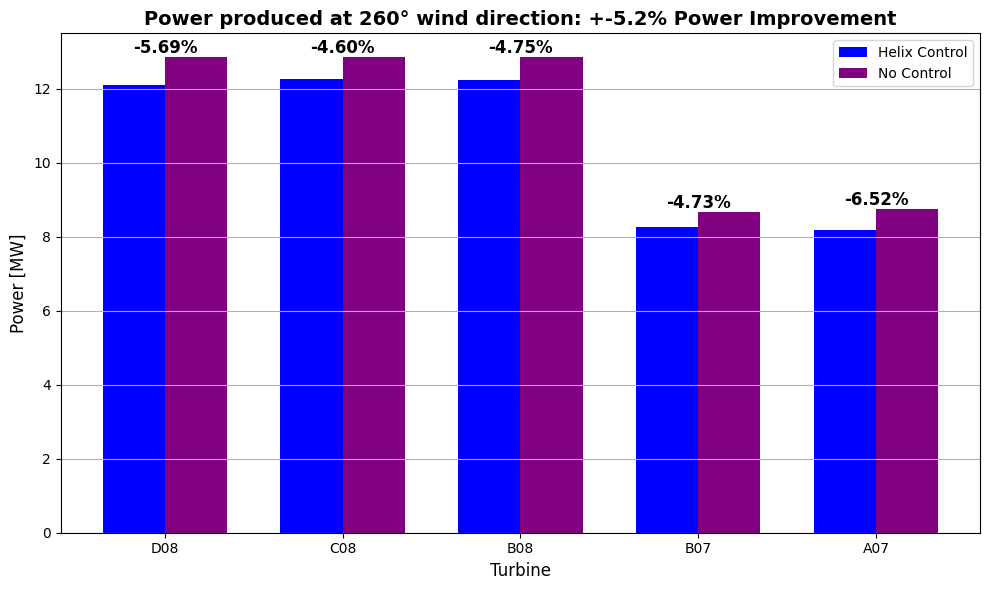

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
wd = 260
# Load the data using the wind direction in the filenames
power = np.loadtxt(f'power_{wd}.txt')
power_nc = np.loadtxt(f'power_{wd}_nocontrol.txt')

Power_improvement=(power-power_nc)/power_nc*100
total_power = np.sum(power)
total_power_nc = np.sum(power_nc)
Power_improvement_total=(total_power-total_power_nc)/total_power_nc*100

# Turbine names
turbine_names = ['D08', 'C08', 'B08', 'B07', 'A07']



# Number of turbines (assume 5 for this example)
num_turbines = len(power)

# Create an array of turbine indices
indices = np.arange(num_turbines)

# Width of the bars
bar_width = 0.35

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bars for 'Control'
plt.bar(indices, power, width=bar_width, color='b', label='Helix Control')

# Plot the bars for 'No Control', offset by bar_width
plt.bar(indices + bar_width, power_nc, width=bar_width, color='purple', label='No Control')

# Adding labels and title
plt.xlabel('Turbine', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title(f'Power produced at {wd}° wind direction: +{round(Power_improvement_total,2)}% Power Improvement', fontsize=14, fontweight='bold')
plt.xticks(indices + bar_width / 2, turbine_names)  # Center the tick labels with turbine names
plt.legend()

# Annotate percentages with signs
for i in range(num_turbines):
    # Determine the sign of improvement
    if Power_improvement[i] >= 0:
        sign = '+'
    else:
        sign = '-'

    # Add annotation with sign
    plt.text(indices[i] + bar_width / 2, max(power[i], power_nc[i]), 
             f'{sign}{abs(Power_improvement[i]):.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Show the plot
plt.tight_layout()
plt.grid(axis='y')

plt.show()



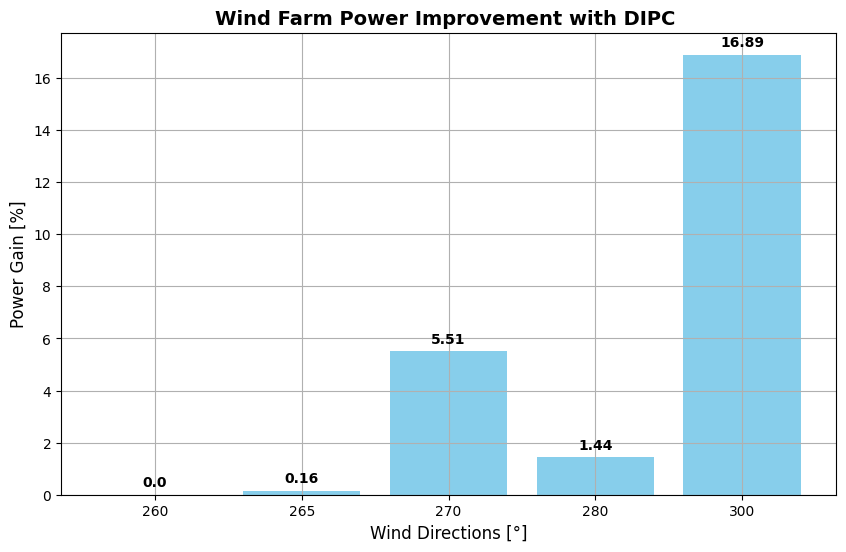

In [11]:
import matplotlib.pyplot as plt

# Data for the plot
wind_directions = ['260', '265', '270', '280', '300']
percentage_power_improvement = [0, 0.16, 5.51, 1.44, 16.89]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(wind_directions, percentage_power_improvement, color='skyblue')

# Add titles and labels
plt.title('Wind Farm Power Improvement with DIPC ', fontsize=14,fontweight='bold')
plt.xlabel('Wind Directions [°]', fontsize=12)
plt.ylabel('Power Gain [%]', fontsize=12)
plt.grid(True)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, round(yval, 2), ha='center', va='bottom',fontweight='bold')
# Display the plot
plt.show()